## Data Processing

In [302]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Activation, GRU, Dense
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler
plt.rcParams['figure.figsize'] = [10, 8]

In [288]:
df = pd.read_csv('wikipedia/web-traffic-time-series-forecasting/train_1.csv', nrows=100)

In [289]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36,10.0


In [290]:
df.isna().sum().sum() # cells with missing values

8369

In [291]:
df.isna().any().sum() # cols with missing values

545

In [292]:
df.isna().any(axis=1).sum() # rows with missing values

32

In [293]:
df.fillna(0, inplace=True) # fill missing vals with 0
df.isna().sum().sum()

0

In [294]:
df.drop("Page", axis=1, inplace=True)

In [295]:
df.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18,20.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26,20.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4,17.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10,11.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36,10.0


## Models

### Simple Moving Average

In [311]:
arr = df.values
arr.shape

(100, 550)

In [312]:
arr[0][:10]

array([18., 11.,  5., 13., 14.,  9.,  9., 22., 26., 24.])

In [313]:
preds = [[0] for i in range(arr.shape[0])]
for i in range(1, arr.shape[1]): # i -> timestep
    for j in range(arr.shape[0]): # j -> webpage
        preds[j].append(sum(arr[j][:i])/i)

In [314]:
mse(preds,arr)

1332.9468521396143

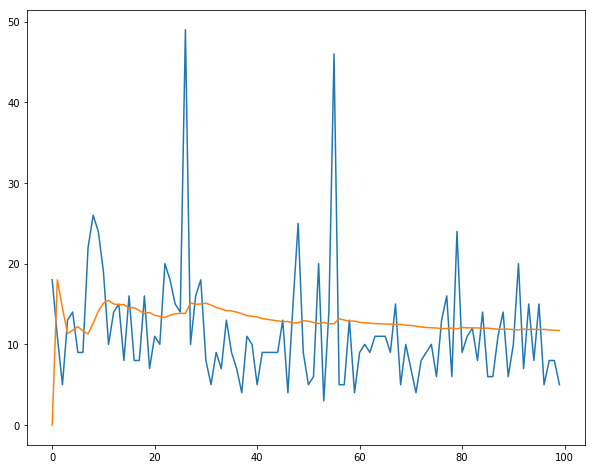

In [315]:
plt.plot(arr[0][:100])
plt.plot(preds[0][:100])

### One-Day Lookback

In [316]:
preds = [[0] for i in range(arr.shape[0])]
for i in range(1, arr.shape[1]): # i -> timestep
    for j in range(arr.shape[0]): # j -> webpage
        preds[j].append(arr[j][i-1])

In [317]:
mse(preds,arr)

1706.4761636363637

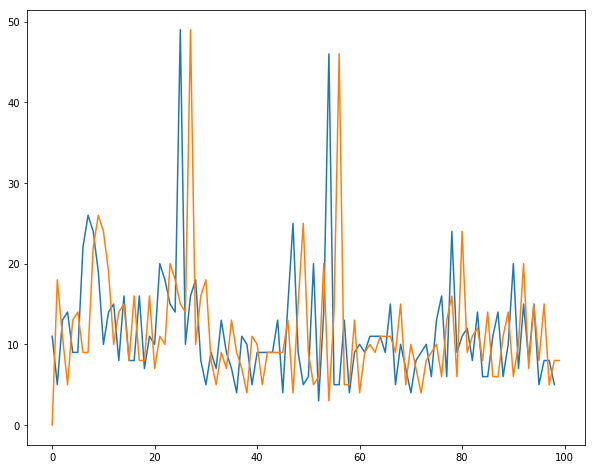

In [318]:
plt.plot(arr[0][1:100])
plt.plot(preds[0][:100])

### Exponential Moving Average

In [319]:
alpha = 0.1
preds = [[0] for i in range(arr.shape[0])]
for i in range(1, arr.shape[1]): # i -> timestep
    for j in range(arr.shape[0]): # j -> webpage
        if i == 1:
            preds[j].append(arr[j][i-1])
        else:
            preds[j].append(alpha*arr[j][i-1] + (1-alpha)*(preds[j][-1]))

In [320]:
mse(preds,arr)

1139.1662642701783

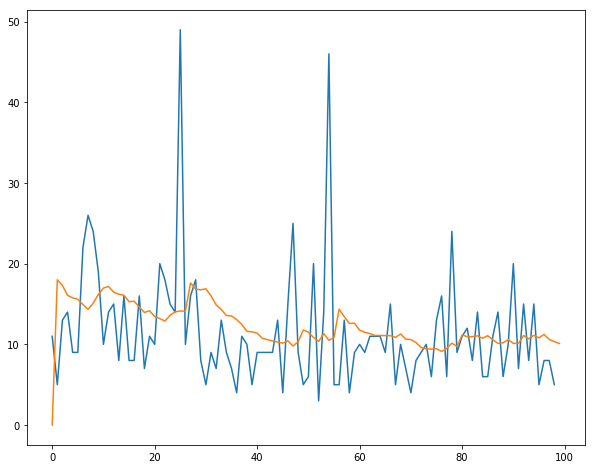

In [321]:
plt.plot(arr[0][1:100])
plt.plot(preds[0][:100])

### GRU-RNN

In [323]:
num_hidden_units = 64
num_outputs = 1
windows = [1, 7, 14, 30]

1183.4169462168227
1520.284899135641
1491.0821038060078
1361.3033941704493


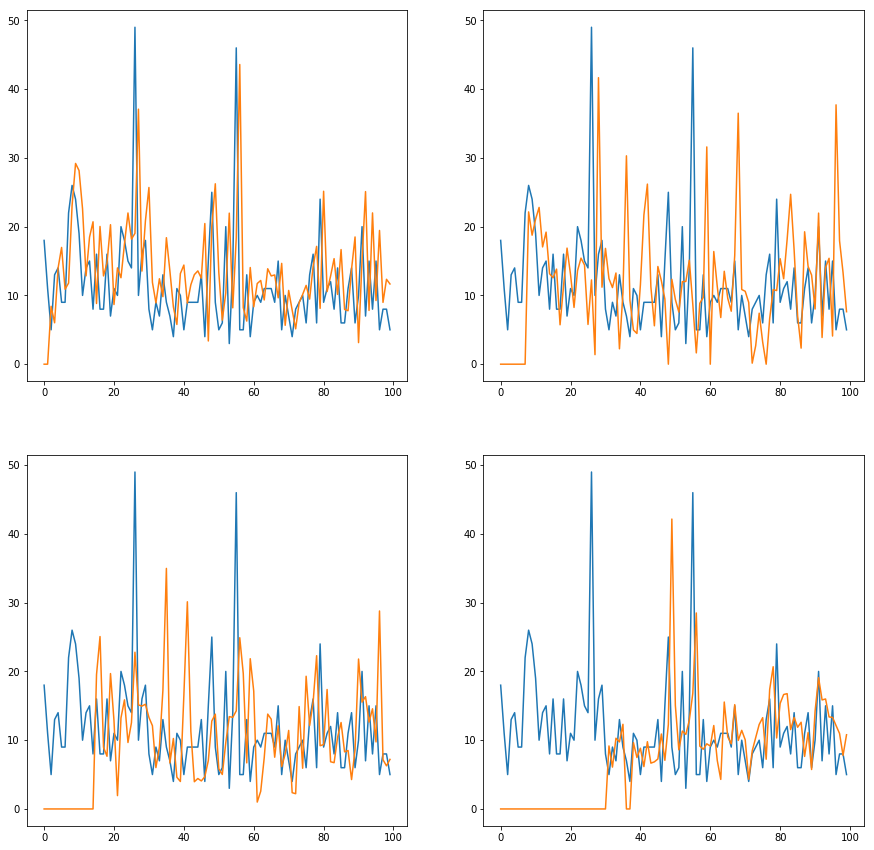

In [324]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        x = np.copy(arr[:, i - window : i]).reshape(-1, window, 1)
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(window):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
    print(mse(preds[:, window:],arr[:, window:]))
    if r <= 1:
        axs[0, r].plot(arr[0][:100])
        axs[0, r].plot(preds[0][:100])
    else:
        axs[1, r-2].plot(arr[0][:100])
        axs[1, r-2].plot(preds[0][:100])

### GRU-Encoder-Decoder

In [325]:
class GruEncoderDecoder:
    def __init__(self, timesteps, hidden_units, pred_steps):
        self.timesteps = timesteps
        self.hidden_units = hidden_units
        self.num_features = 1
        self.pred_steps = pred_steps
        encoder_inputs = Input(shape=(self.timesteps, self.num_features))
        self.encoder = GRU(self.hidden_units, return_state=True)
        encoder_outputs, encoder_h = self.encoder(encoder_inputs)
        decoder_inputs = Input(shape=(None, self.num_features))
        self.decoder = GRU(self.hidden_units, return_state=True, return_sequences=True)
        decoder_outputs, _ = self.decoder(decoder_inputs, initial_state=encoder_h)
        self.decoder_dense = Dense(1, activation='relu')
        decoder_outputs = self.decoder_dense(decoder_outputs)

        # training architecture
        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        self.model.compile(loss='mse', optimizer='adam')

        # inference architecture
        self.inference_encoder = Model(encoder_inputs, encoder_h)
        decoder_input_h = Input(shape=(self.hidden_units,))
        decoder_outputs, decoder_output_h = self.decoder(decoder_inputs, initial_state=decoder_input_h)
        decoder_outputs = self.decoder_dense(decoder_outputs)
        self.inference_decoder = Model([decoder_inputs, decoder_input_h], [decoder_outputs, decoder_output_h])

    def predict(self, encoder_input, scaler):
        decoder_input_h = self.inference_encoder.predict(encoder_input)
        target_seq = encoder_input[:, -1, :].reshape(-1, 1, 1)
        num_samples = encoder_input.shape[0]
        decoded_seq = np.zeros((num_samples, self.pred_steps, 1))
        for i in range(self.pred_steps):
            decoder_output, decoder_input_h = self.inference_decoder.predict([target_seq, decoder_input_h])
            for j in range(num_samples): 
                decoded_seq[j, i, 0] = decoder_output[j, 0, 0]
            target_seq = scaler.transform(decoder_output.reshape(-1,1)).reshape(-1,1,1)
        return decoded_seq

    def fit(self, encoder_input, decoder_input, decoder_output, epochs, verbose):
        self.model.fit([encoder_input, decoder_input], decoder_output, epochs=epochs, verbose=verbose)

In [326]:
num_hidden_units = 64
pred_steps = [[1], [1, 7], [1, 7, 14]]
windows = [1, 7, 14]

1304.302427371538
1500.4408013122309
1556.099730277255
1508.6310674909873
1478.1354435391318
1600.4389568088166


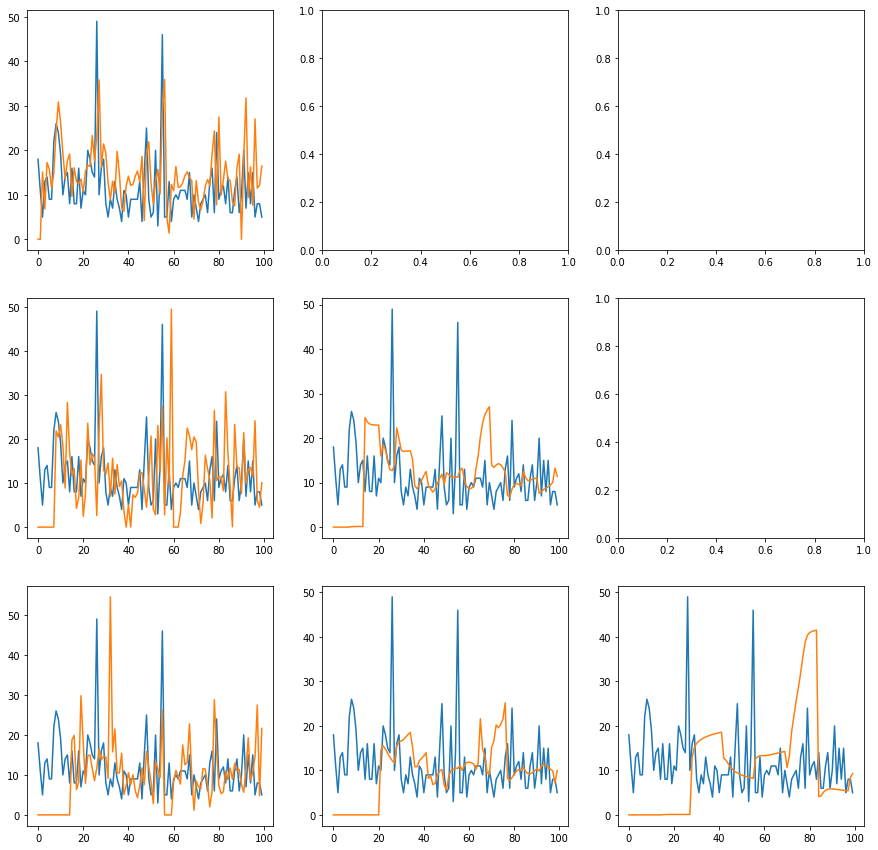

In [327]:
f, axs = plt.subplots(3, 3, figsize=(15, 15))
for r, window in enumerate(windows):
    for j, pred_step in enumerate(pred_steps[r]): 
        model = GruEncoderDecoder(window, num_hidden_units, pred_step)
        preds = np.zeros((arr.shape[0], arr.shape[1]))
        scaler = StandardScaler()
        for w in range(window):
            preds[:, w] = 0
        for i in range(window, arr.shape[1] - pred_step + 1, pred_step): # i -> timestep
            enc_in = np.copy(arr[:, i - window : i]).reshape(-1, window, 1)
            dec_in = np.copy(arr[:, i - 1 : i + pred_step - 1]).reshape(-1, pred_step, 1)
            dec_out = np.copy(arr[:, i : i + pred_step]).reshape(-1, pred_step, 1)
            for k in range(window):
                enc_in[:, k, :] = scaler.fit_transform(enc_in[:, k, :])
            for k in range(pred_step):
                dec_in[:, k, :] = scaler.transform(dec_in[:, k, :])
            p = model.predict(enc_in, scaler).reshape(-1, pred_step)
            preds[:, i : i + pred_step] = p
            model.fit(enc_in, dec_in, dec_out, epochs=100, verbose=0)
        print(mse(preds[:, window:],arr[:, window:]))
        axs[r, j].plot(arr[0][:100])
        axs[r, j].plot(preds[0][:100])

### Remodeling Data as Individual Web Requests